In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import commonutils
import models

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from dataclasses import dataclass
import prettyprinter as pp

from sklearn.cross_decomposition import PLSRegression
import warnings
import sys

from sklearn import preprocessing

from copy import deepcopy
import pickle

In [2]:
warnings.simplefilter("ignore")

howmanydifs = 3
allvalues_perset = pickle.load(open("./data/allvalues_perset.p", "rb"))
methods = pickle.load(open("./data/methods.p", "rb"))
fullsetnames = pickle.load(open("./data/fullsetnames.p", "rb"))
functionals = pickle.load(open("./data/functionals.p", "rb"))
basis_sets = pickle.load(open("./data/basis_sets.p", "rb"))
supersetnames = pickle.load(open("./data/supersetnames.p", "rb"))

In [3]:
from importlib import reload
reload(commonutils)

from commonutils import ModelResults

allfeatures = set()
for setname in fullsetnames:
    for val in allvalues_perset[setname]:
        for k in val:
            if k.find("energydiff") != -1:
                for f in val[k]:
                    allfeatures.add(f)

# set labels and sets iists
models_results = {}
for setname in fullsetnames:
    models_results[setname] = ModelResults()
    for val in allvalues_perset[setname]:
        models_results[setname].labels.append(val["label"]) 
        models_results[setname].supersetnames.append(val["super_setname"])
        models_results[setname].setnames.append(val["super_setname"]+"_"+val["setname"])

insidemethods = ["W","D3(0)","D3(BJ)"]
for setname in fullsetnames:
    for methodid in range(howmanydifs):
        y_pred = []
        for val in allvalues_perset[setname]:
            y_pred.append(val["label"] + val["difs"][methodid])

        wtmad = None
        fulllist = list(supersetnames.keys()) + ["Full"]
        if setname in fulllist:
            wtmadf = commonutils.wtmad2(models_results[setname].setnames, \
                                    models_results[setname].labels, y_pred)
            wtmad = wtmadf[setname]

            if wtmad < models_results[setname].bestinsidemethod_wtmad:
                models_results[setname].bestinsidemethod_wtmad = wtmad
                models_results[setname].bestinsidemethod_name_wtmad = insidemethods[methodid]
                models_results[setname].y_pred_bestinsidemethod_wtmad = y_pred

        rmse = mean_squared_error(models_results[setname].labels, \
                                y_pred, squared=False)

        if rmse < models_results[setname].bestinsidemethod_rmse:
            models_results[setname].bestinsidemethod_rmse = rmse
            models_results[setname].bestinsidemethod_name_rmse = insidemethods[methodid]
            models_results[setname].y_pred_bestinsidemethod_rmse = y_pred

    for j, method in enumerate(methods):
        y_pred = []
        for val in allvalues_perset[setname]:
            y_pred.append(val[method + "_energydiff"][method+"_FINAL_SINGLE_POINT_ENERGY"])

        wtmad = None            
        fulllist = list(supersetnames.keys()) + ["Full"]
        if setname in fulllist:
            wtmadf = commonutils.wtmad2(models_results[setname].setnames, \
                                models_results[setname].labels, y_pred)
            wtmad = wtmadf[setname]

            if wtmad < models_results[setname].bestourmethod_wtmad:
                models_results[setname].bestourmethod_wtmad = wtmad
                models_results[setname].bestourmethod_name_wtmad = method
                models_results[setname].y_pred_bestourmethod_wtmad = y_pred
        
        rmse = mean_squared_error(models_results[setname].labels,\
                                y_pred, squared=False)

        if rmse < models_results[setname].bestourmethod_rmse:
            models_results[setname].bestourmethod_rmse = rmse
            models_results[setname].bestourmethod_name_rmse = method
            models_results[setname].y_pred_bestourmethod_rmse = y_pred

bestmnethodscount = {}
setofbestourmethodswtamd = {}

print("Results for inside and our methods")
print("%40s"% "Dataset", " , ", \
    "Best inside method RMSE", " , ", \
    "RMSE", " , ", \
    "Best inside method WTMAD2", " , ", \
    "WTMAD2", " , ", \
    "Best our method RMSE", " , ", \
    "RMSE", " , ", \
    "Best our method WTMAD2", " , ", \
    "WTMAD2")
for setname in fullsetnames:
    if models_results[setname].bestourmethod_name_rmse in bestmnethodscount:
        bestmnethodscount[models_results[setname].bestourmethod_name_rmse] += 1
    else:
        bestmnethodscount[models_results[setname].bestourmethod_name_rmse] = 1

    if models_results[setname].bestourmethod_name_wtmad != "":
        if models_results[setname].bestourmethod_name_wtmad in setofbestourmethodswtamd:
            setofbestourmethodswtamd[models_results[setname].bestourmethod_name_wtmad] += 1
        else:
            setofbestourmethodswtamd[models_results[setname].bestourmethod_name_wtmad] = 1
          
    print("%40s"%setname, " , ", \
        "%10s"%models_results[setname].bestinsidemethod_name_rmse , " , ",\
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%10s"%models_results[setname].bestinsidemethod_name_wtmad , " , ", \
        "%7.3f"%models_results[setname].bestinsidemethod_wtmad, " , ", \
        "%10s"%models_results[setname].bestourmethod_name_rmse , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
        "%10s"%models_results[setname].bestourmethod_name_wtmad , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_wtmad)

Results for inside and our methods
                                 Dataset  ,  Best inside method RMSE  ,  RMSE  ,  Best inside method WTMAD2  ,  WTMAD2  ,  Best our method RMSE  ,  RMSE  ,  Best our method WTMAD2  ,  WTMAD2
                         BARRIER_HEIGHTS  ,           W  ,    7.999  ,           W  ,   17.190  ,  wB97XV-QZVP  ,    2.089  ,  M062X-QZVP  ,    3.810
                    BARRIER_HEIGHTS_BH76  ,           W  ,    9.986  ,              ,      inf  ,  M062X-QZVP  ,    1.464  ,              ,      inf
                 BARRIER_HEIGHTS_BHDIV10  ,           W  ,    9.191  ,              ,      inf  ,  wB97XV-QZVP  ,    1.159  ,              ,      inf
                  BARRIER_HEIGHTS_BHPERI  ,           W  ,    4.473  ,              ,      inf  ,  M062X-QZVP  ,    1.816  ,              ,      inf
                 BARRIER_HEIGHTS_BHROT27  ,       D3(0)  ,    0.611  ,              ,      inf  ,  wB97XV-QZVP  ,    0.422  ,              ,      inf
                   BARRIER

In [4]:
print("RMSE")
for method in bestmnethodscount:
    print("Best our method ", method, " count: ", bestmnethodscount[method])

print()
print("WTMAD2")
for method in setofbestourmethodswtamd:
    print("Best our method ", method, " count: ", setofbestourmethodswtamd[method])


RMSE
Best our method  wB97XV-QZVP  count:  19
Best our method  M062X-QZVP  count:  13
Best our method  TPSSh-QZVP  count:  4
Best our method  wB97XD3-QZVP  count:  7
Best our method  PBE0-QZVP  count:  3
Best our method  M062X-SVP  count:  1
Best our method  M062X-TZVP  count:  6
Best our method  TPSSh-TZVP  count:  1
Best our method  PBE-QZVP  count:  2
Best our method  PBE0-TZVP  count:  3
Best our method  wB97XV-TZVP  count:  1
Best our method  PBE0-SVP  count:  1

WTMAD2
Best our method  M062X-QZVP  count:  3
Best our method  wB97XV-QZVP  count:  3


In [5]:
#filter and generate equations
basicfeattouse = ["Potential_Energy", \
                "Kinetic_Energy", \
                "FINAL_SINGLE_POINT_ENERGY", \
                "Dispersion_correction", \
                "E(C)", \
                "E(X)", \
                "Two_Electron_Energy", \
                "Nuclear_Repulsion", \
                "One_Electron_Energy"]

featuresvalues_perset = {}
for setname in fullsetnames:
    featuresvalues_perset [setname] = []
    for val in allvalues_perset[setname]:
        featuresvalues_perset[setname].append({})
        for k in val:
            if k.find("energydiff") != -1:
                torm = k.replace("energydiff", "")
                for f in val[k]:
                    tocheck = f.replace(torm, "")
                    if tocheck in basicfeattouse:
                        keytouse = f.replace("-", "_")
                        keytouse = keytouse.replace("(", "")
                        keytouse = keytouse.replace(")", "")
                        featuresvalues_perset[setname][-1][keytouse] = val[k][f]

# for debug purposes
#for val in featuresvalues_perset:
#    print("======= START =======")
#    print(val, len(featuresvalues_perset[val]))
#    pp.pprint(featuresvalues_perset[val])
#    print("=======  END  =======")


In [6]:

equations = {"EQ1" :"power(FINAL_SINGLE_POINT_ENERGY, 2) + multiply(Dispersion_correction, 2)", \
             "EQ1" : "FINAL_SINGLE_POINT_ENERGY", \
             "EQ2" : "One_Electron_Energy + Two_Electron_Energy + Dispersion_correction + Nuclear_Repulsion", \
             "EQ3" : "multiply(Potential_Energy, Dispersion_correction)", \
             "EQ4" : "Nuclear_Repulsion"}

equations = {"EC" :"EC" , \
            "EX" : "EX", \
            "FSPE" : "FINAL_SINGLE_POINT_ENERGY", \
            "DC" : "Dispersion_correction", \
            "PE" : "Potential_Energy", \
            "KE" : "Kinetic_Energy", \
            "OEE" : "One_Electron_Energy", \
            "TEE" : "Two_Electron_Energy", \
            "NR" : "Nuclear_Repulsion"}

# FINAL_SINGLE_POINT_ENERGY = 
# 1 - Kinetic_Energy+(One_Electron_Energy-Kinetic_Energy) + EX + EC 
# 2 - (Two_Electron_Energy-EX-EC) + Dispersion_correction+ Nuclear_Repulsion
# 3 -One_Electron_Energy + Two_Electron_Energy + Dispersion_correction + Nuclear_Repulsion"
# 4 - Kinetic_Energy + Potential_Energy + Dispersion_correction

eq_featuresvalues_perset = \
    commonutils.equation_parser_compiler(equations, functionals, basis_sets, basicfeattouse, \
                              featuresvalues_perset)

# for debug purposes
#for setname in featuresvalues_perset:
#    print("Equations for ", setname , " set ", len(featuresvalues_perset[setname]))
#    pp.pprint(eq_featuresvalues_perset[setname])

featuresvalues_perset = deepcopy(eq_featuresvalues_perset)

Warning  Dispersion_correction  not in or undefined function  M062X MINIX
Warning  Dispersion_correction  not in or undefined function  M062X MINIX
Warning  Dispersion_correction  not in or undefined function  M062X SVP
Warning  Dispersion_correction  not in or undefined function  M062X SVP
Warning  Dispersion_correction  not in or undefined function  M062X TZVP
Warning  Dispersion_correction  not in or undefined function  M062X TZVP
Warning  Dispersion_correction  not in or undefined function  M062X QZVP
Warning  Dispersion_correction  not in or undefined function  M062X QZVP
Warning  Dispersion_correction  not in or undefined function  wB97XV MINIX
Warning  Dispersion_correction  not in or undefined function  wB97XV MINIX
Warning  Dispersion_correction  not in or undefined function  wB97XV SVP
Warning  Dispersion_correction  not in or undefined function  wB97XV SVP
Warning  Dispersion_correction  not in or undefined function  wB97XV TZVP
Warning  Dispersion_correction  not in or unde

In [7]:
functional_to_use = "PBE"
basissets_touse = ["MINIX", "SVP"]

labels = []
features = {}
supersetnameslist = list(supersetnames.keys())
for setname in featuresvalues_perset:
    if setname in supersetnameslist:
        print("Setname: ", setname)
        for entry in featuresvalues_perset[setname]:
            labels.append(supersetnameslist.index(setname))
            #print("Entry: ", entry)
            for featurename in entry:
                if featurename.startswith(functional_to_use+"_"):
                    for basisset in basissets_touse:
                        if featurename.find(basisset) != -1:
                            if featurename not in features:
                                features[featurename] = []
                            features[featurename].append(entry[featurename])


Setname:  BARRIER_HEIGHTS
Setname:  INTRAMOLECULAR_INTERACTIONS
Setname:  SMALL_MOLECULES
Setname:  INTERMOLECULAR_INTERACTIONS
Setname:  LARGE_SYSTEMS


In [8]:
for k in features:
    print(k, len(features[k]))

print("Labels: ", len(labels))

PBE_MINIX_EC 1440
PBE_MINIX_EX 1440
PBE_MINIX_FSPE 1440
PBE_MINIX_DC 1440
PBE_MINIX_PE 1440
PBE_MINIX_KE 1440
PBE_MINIX_OEE 1440
PBE_MINIX_TEE 1440
PBE_MINIX_NR 1440
PBE_SVP_EC 1440
PBE_SVP_EX 1440
PBE_SVP_FSPE 1440
PBE_SVP_DC 1440
PBE_SVP_PE 1440
PBE_SVP_KE 1440
PBE_SVP_OEE 1440
PBE_SVP_TEE 1440
PBE_SVP_NR 1440
Labels:  1440


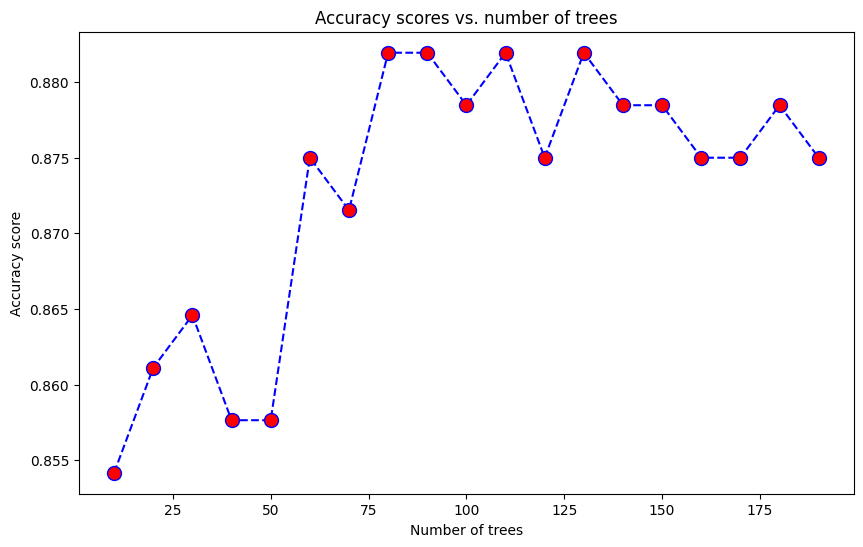

Best accuracy score:  0.8819444444444444  with  80  trees


In [9]:
# build a classification model using RF 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = []
for k in features:
    X.append(features[k])

X = np.array(X).T
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

accuracy_scores = []

for numoftrees in range(10, 200, 10):
    rf = RandomForestClassifier(n_estimators=numoftrees, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# plot the accuracy scores
plt.figure(figsize=(10,6))
plt.plot(range(10, 200, 10), accuracy_scores, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Accuracy scores vs. number of trees')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy score')
plt.show()

print("Best accuracy score: ", max(accuracy_scores), " with ", (accuracy_scores.index(max(accuracy_scores))+1)*10, " trees")


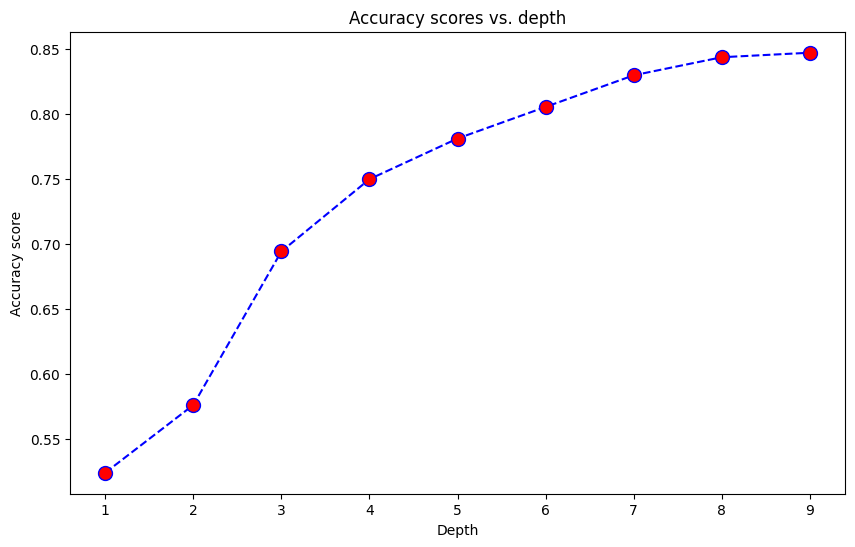

Best accuracy score:  0.8472222222222222  with  9  depth


In [10]:
bestnumoftree   = (accuracy_scores.index(max(accuracy_scores))+1)*10

accuracy_scores = []
for depth in range(1, 10):
    rf = RandomForestClassifier(n_estimators=bestnumoftree, max_depth=depth, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# plot the accuracy scores
plt.figure(figsize=(10,6))
plt.plot(range(1, 10), accuracy_scores, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Accuracy scores vs. depth')
plt.xlabel('Depth')
plt.ylabel('Accuracy score')
plt.show()

print("Best accuracy score: ", max(accuracy_scores), " with ", (accuracy_scores.index(max(accuracy_scores))+1), " depth")

In [11]:
rf = RandomForestClassifier(n_estimators=bestnumoftree,  \
                            random_state=42)
rf.fit(X, y)
# predict the labels and accuracy 
y_pred = rf.predict(X)
accuracy = accuracy_score(y, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  1.0


In [12]:
# model tio use 
rf = RandomForestClassifier(n_estimators=bestnumoftree,  \
                            random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(" Test Accuracy: ", accuracy)
y_pred = rf.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print("Train Accuracy: ", accuracy)
y_pred = rf.predict(X)
accuracy = accuracy_score(y, y_pred)
print("Total Accuracy: ", accuracy)

 Test Accuracy:  0.8819444444444444
Train Accuracy:  1.0
Total Accuracy:  0.9763888888888889


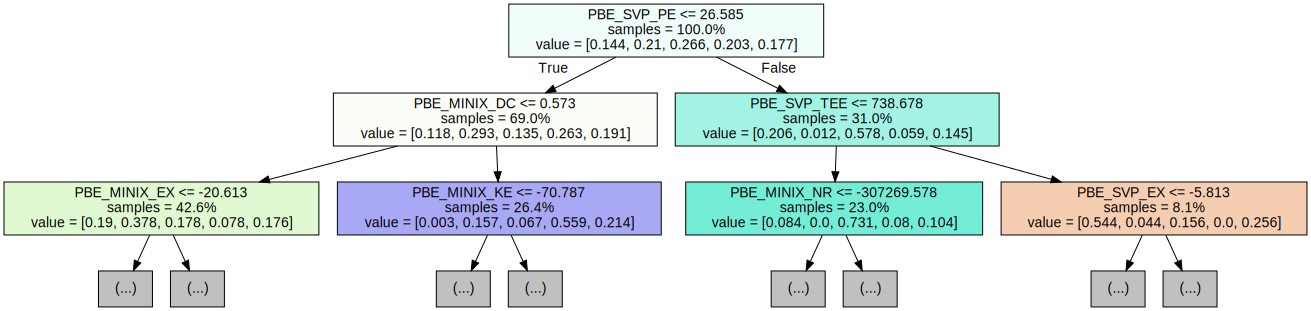

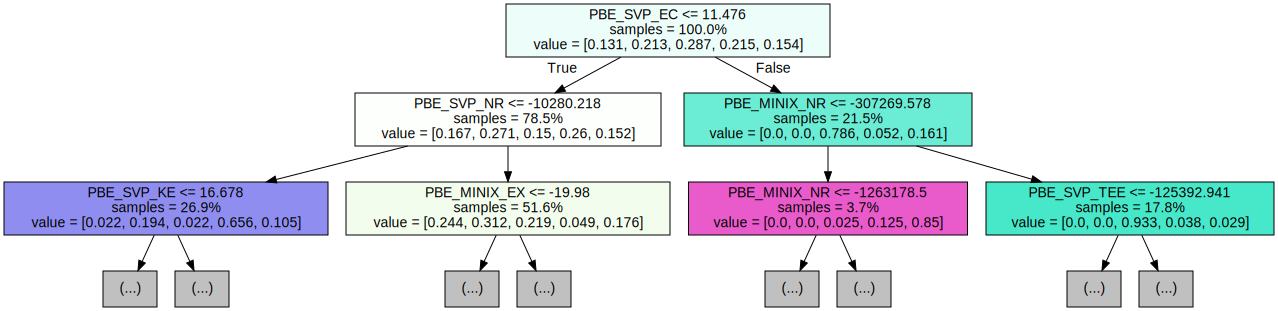

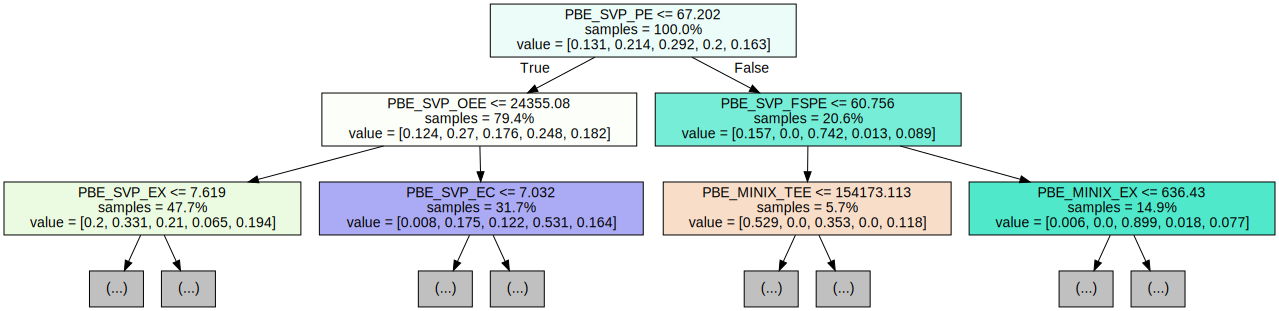

In [14]:
# use graphviz to visualize the tree
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz


for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=list(features.keys()),  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)